#Step 1: Pip Install and Import Libraries

##1a) Import Data Manipulation Libraries

In [3]:
!pip install pandas==1.3.5

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Install TALIB---------------------------------------------------------
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

!pip install Ta-Lib
import talib as ta

#Install Pyfolio------------------------------------------------------
!pip install pyfolio
import pyfolio as pf

#Install Yahoo Finance------------------------------------------------
!pip install yfinance
import yfinance as yf

--2024-12-20 15:11:07--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-12-20 15:11:07--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://deac-fra.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-12-20 15:11:07--  http://deac-fra.dl.sour

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(




---



#Step 2: Import Dataset & Plot

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI
Date,,,,,,
2022-01-03,25.504265,29.809090,29.845453,29.745455,29.818180,1771660
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720
2022-01-05,25.854284,30.218182,30.772726,30.063637,30.727272,5120060
2022-01-06,26.305410,30.745455,30.745455,29.963636,29.981817,5170110
2022-01-07,26.733206,31.245455,31.245455,30.945454,31.045454,5531460
...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300


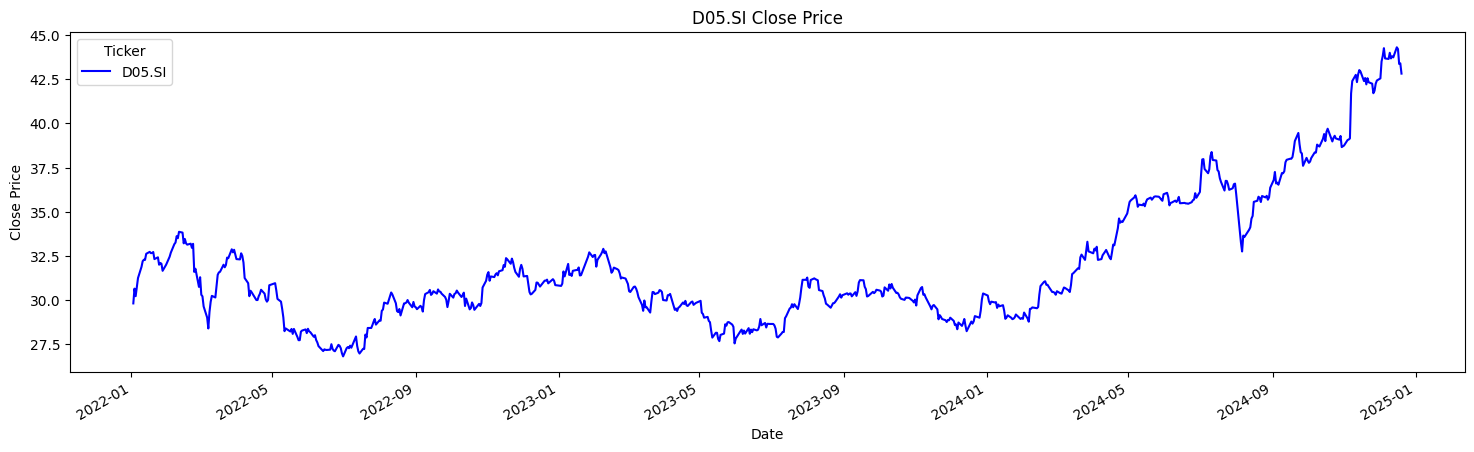

In [5]:
ticker = 'D05.SI'
data = yf.download(ticker,start='2022-01-01')
display(data)

#we only want the Close price
#data = pd.DataFrame(data['Close'])
#display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Create a Function to Define Features and Target

Mission:
- we are trying to define X to predict y
- y is the Stock Close Price
- X will contain arbitary features defined by us that we believe can be used as indicators to predict y  
- later on, we will use X and y to train the Logistic Regression Model to assist with the prediction

In [6]:
import numpy as np
import talib as ta

def get_target_features(data):
    # -------------------------------------------------------------
    # Define Features (X)
    # Volatility (using pct_change for percentage change)
    data['PCT_CHANGE'] = data['Close'].pct_change().squeeze()
    data['VOLATILITY'] = data['PCT_CHANGE'].rolling(14).std() * 100

    # Correlation (using SMA for correlation calculation)
    data['SMA'] = ta.SMA(data['Close'].squeeze(),
                         timeperiod=14)
    data['CORR'] = ta.CORREL(data['Close'].squeeze(),
                             data['SMA'], timeperiod=14)

    # RSI (unused)
    data['RSI'] = ta.RSI(data['Close'].values.squeeze(),
                         timeperiod=14)

    # ADX (unused)
    data['ADX'] = ta.ADX(data['High'].values.squeeze(),
                         data['Low'].values.squeeze(),
                         data['Close'].values.squeeze(),
                         timeperiod=14)

    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    # Drop NaN rows (necessary after rolling and shifting operations)
    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR', 'RSI', 'ADX']]


##Features, X: Volatility & Correlation

###1) PCT_CHANGE(): (we use it to get Volatility)
- (current value — previous value) / previous value * 100
- Basically, it tells us how today is performing compared to yesterday.
- "if u had bought YESETERDAY, this would have been your returns TODAY..."

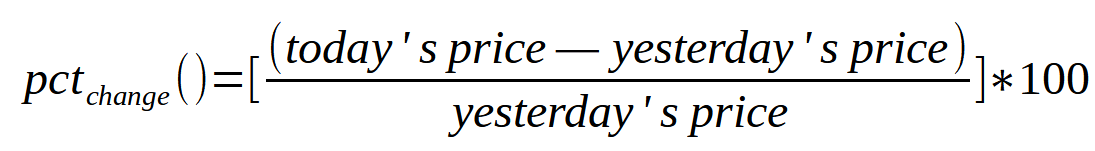

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,
Date,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263
...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257


<Axes: xlabel='Date'>

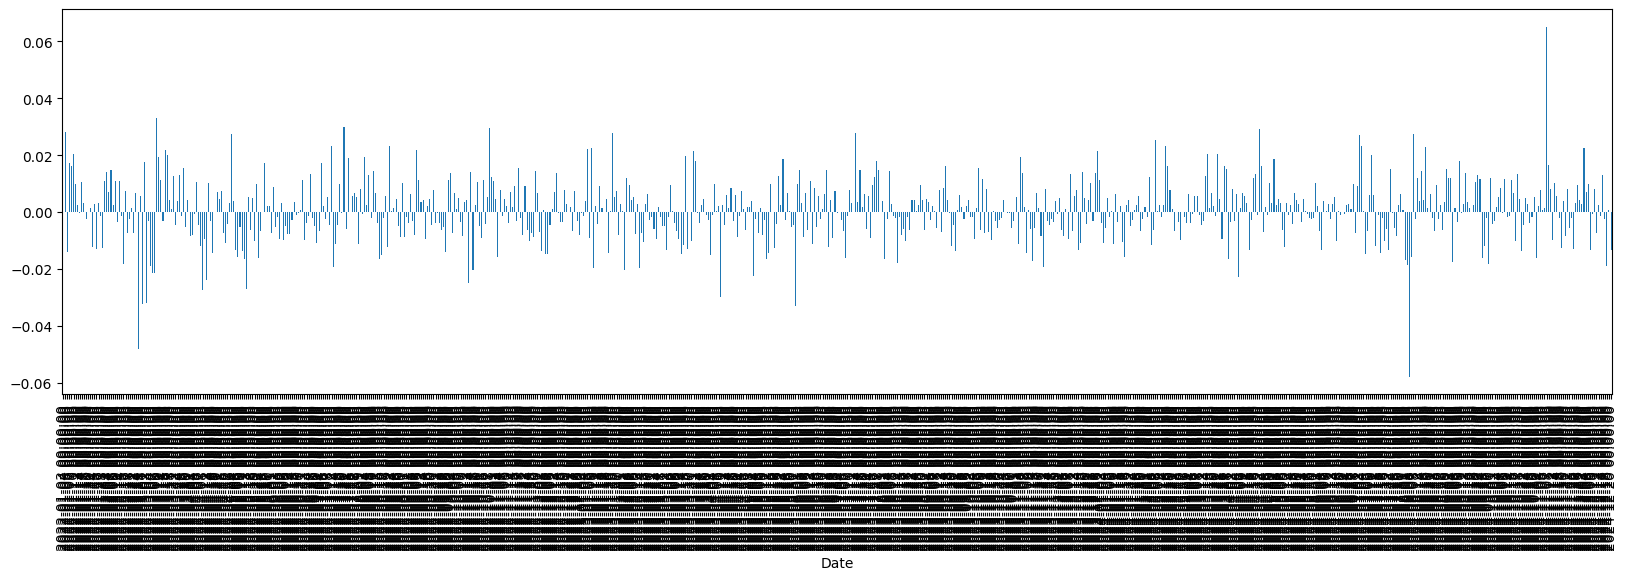

In [ ]:
data['PCT_CHANGE'] = data['Close'].pct_change()
display(data)
#notice a new column "pct_change" has been created

data['PCT_CHANGE'].plot(kind='bar', figsize=(20,5))



---



###2) Volatility

- Volatility is measured by the standard deviation of the asset over a given period of time.
- The higher the standard deviation, the higher the volatility.

- In general, a volatility of 10% or less is considered to be low
- A volatility of 20% or more is considered to be high.

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,
Date,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN
...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969


<Axes: xlabel='Date'>

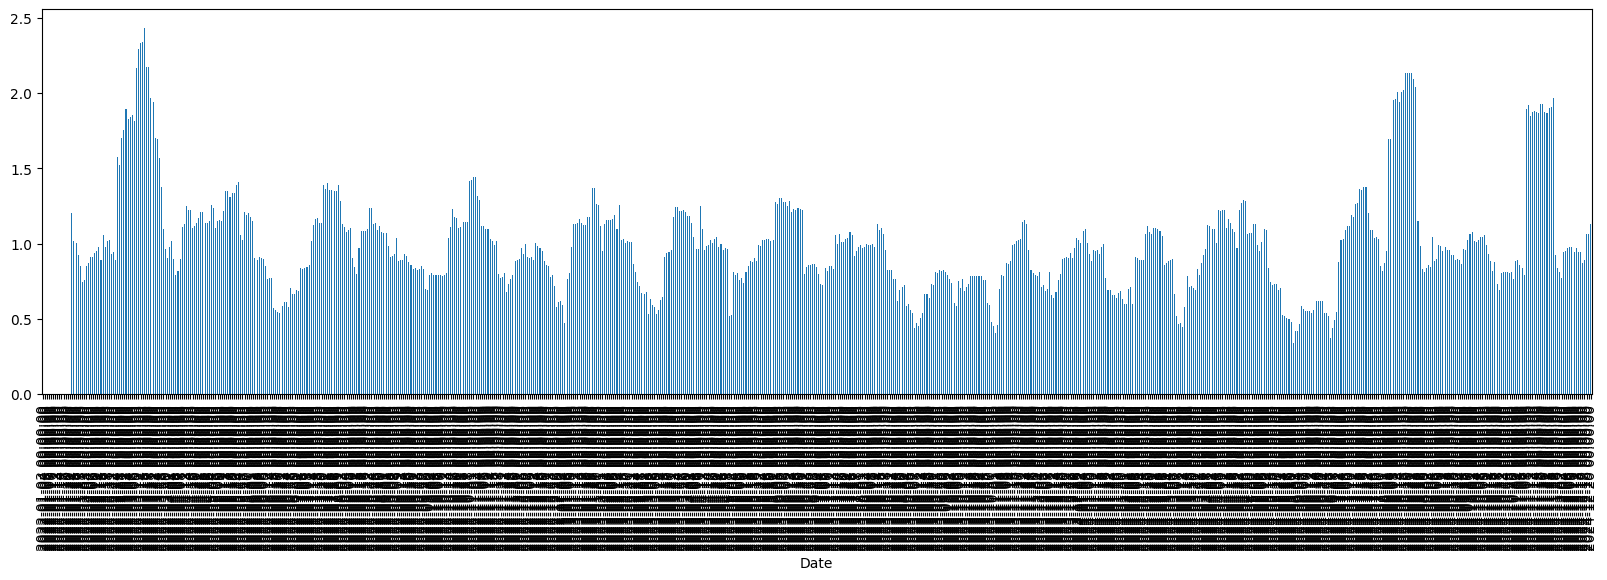

In [ ]:
data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100
display(data)
#notice a new column "volatility" has been created

data['VOLATILITY'].plot(kind='bar', figsize=(20,5))
#perhaps we should only buy when there's great volatility?



---



###3) SMA (we use the SMA to get the Corr)

How does SMA work?

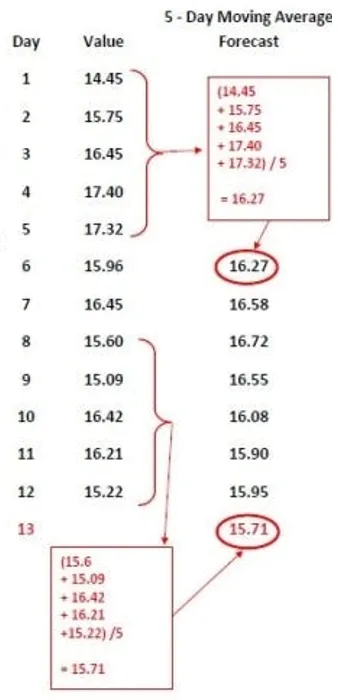

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,
Date,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571


<Axes: xlabel='Date'>

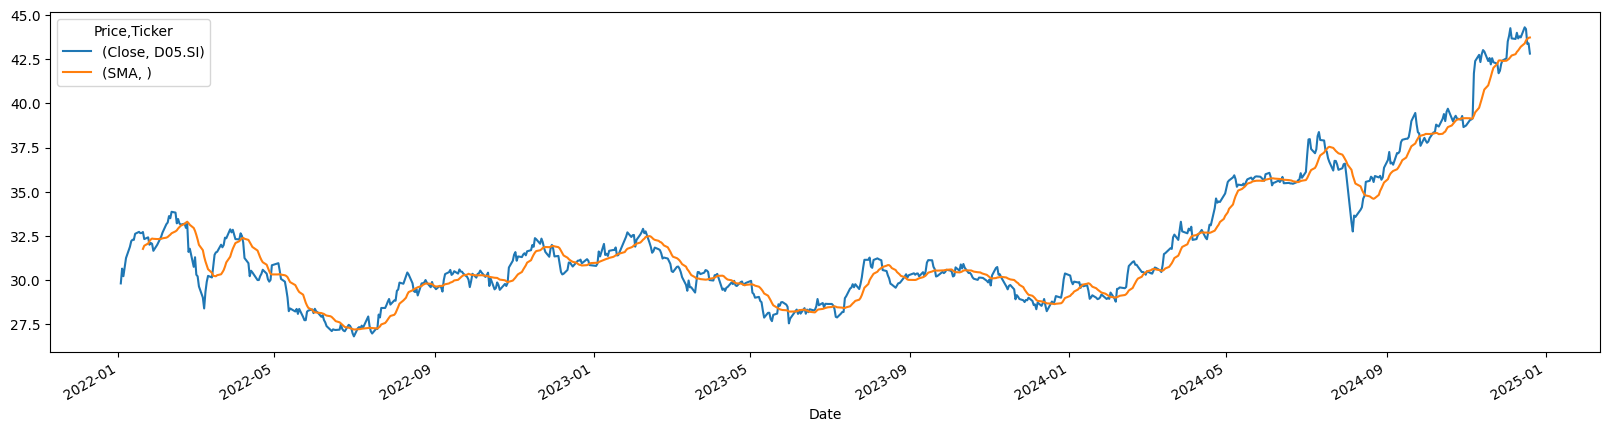

In [ ]:
data['SMA'] = ta.SMA(data['Close'].squeeze(),14)
display(data)


data[['Close', 'SMA']].plot(figsize=(20,5))



---



###4) Correlation

- Correlation coefficient is between -1 and 1.
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation.

- The corr function calculates the correlation between 'Close' and 'SMA' over a window of 14 days.

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,
Date,,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN,NaN
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN,NaN
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN,NaN
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000,0.680818
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571,0.686169


<Axes: xlabel='Date'>

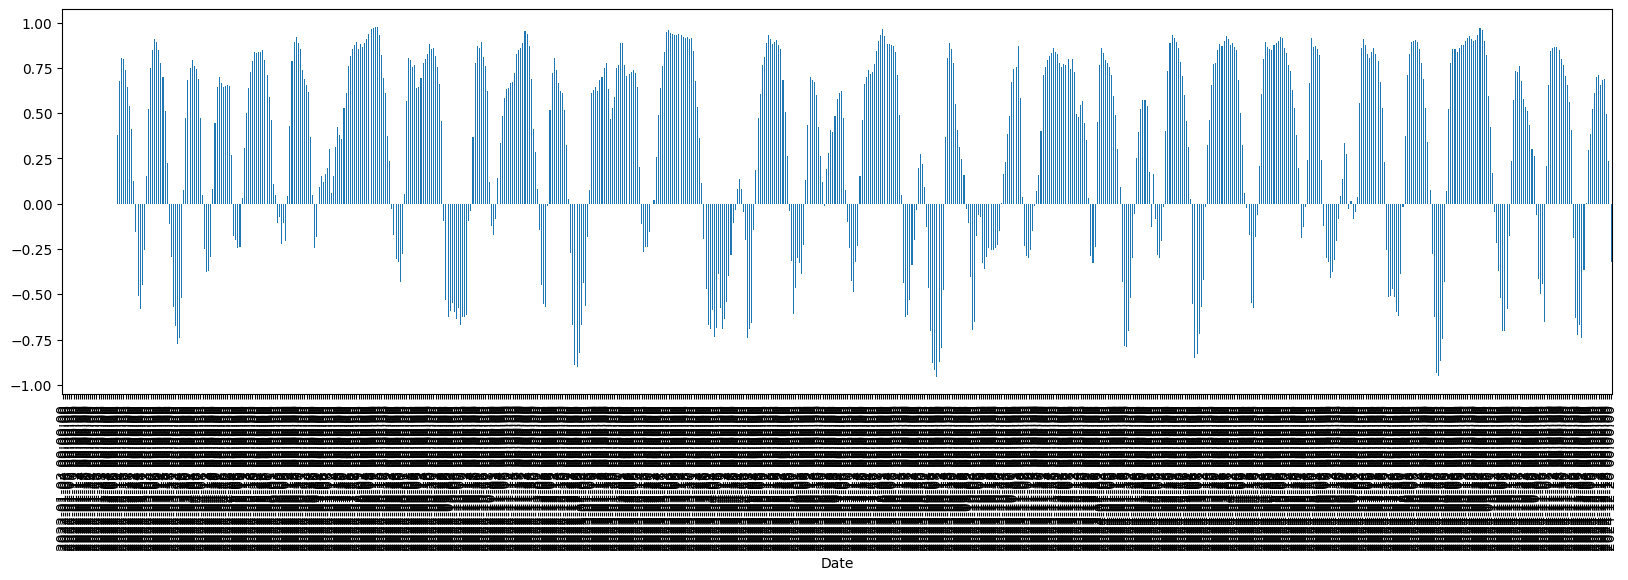

In [ ]:
data['CORR'] = ta.CORREL(data['Close'].squeeze(), data['SMA'], 14)
display(data)

data['CORR'].plot(kind='bar', figsize=(20,5))

#SMA and the Close price is supposed to move together,
#but u can see that sometimes it doesn't.
#perhaps when there's -ve correlation, we shouldn't buy?



---



###5) RSI

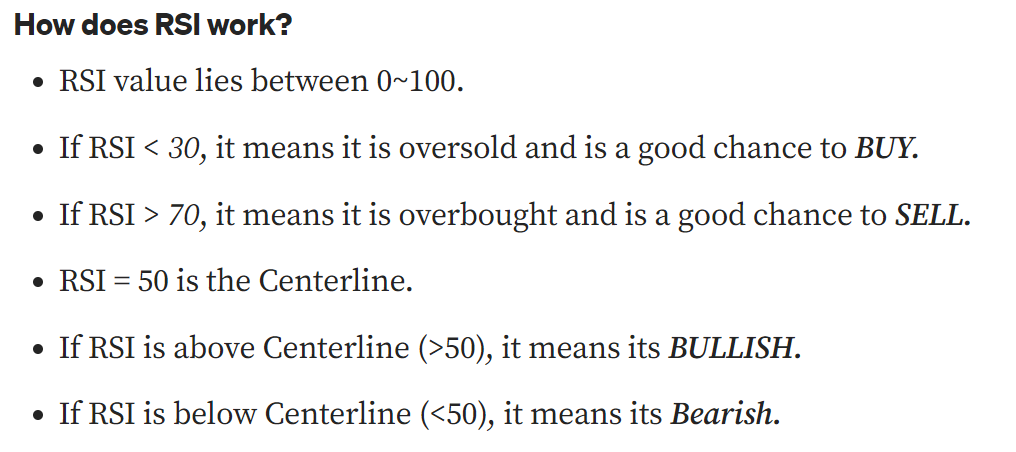

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,
Date,,,,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN,NaN,NaN,NaN
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN,NaN,NaN,NaN
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN,NaN,NaN,NaN
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000,0.680818,68.506640,32.089939
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571,0.686169,66.971051,32.278253


<Axes: xlabel='Date'>

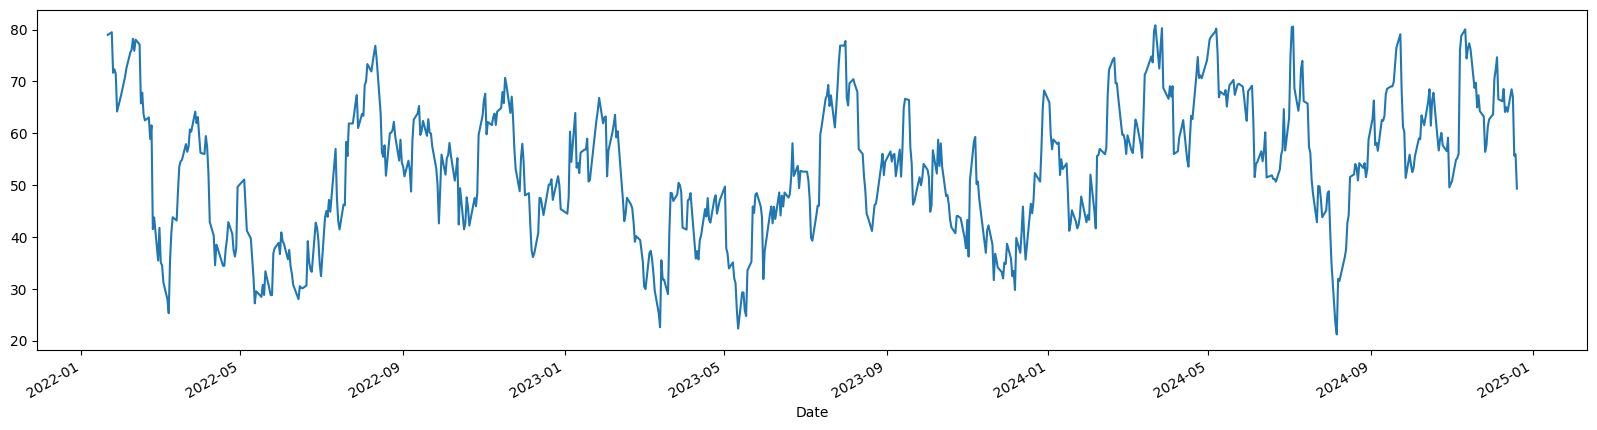

In [ ]:
data['RSI'] = ta.RSI(data['Close'].values.squeeze(), timeperiod=14)
display(data)

data['RSI'].plot(figsize=(20,5))



---



###6) ADX

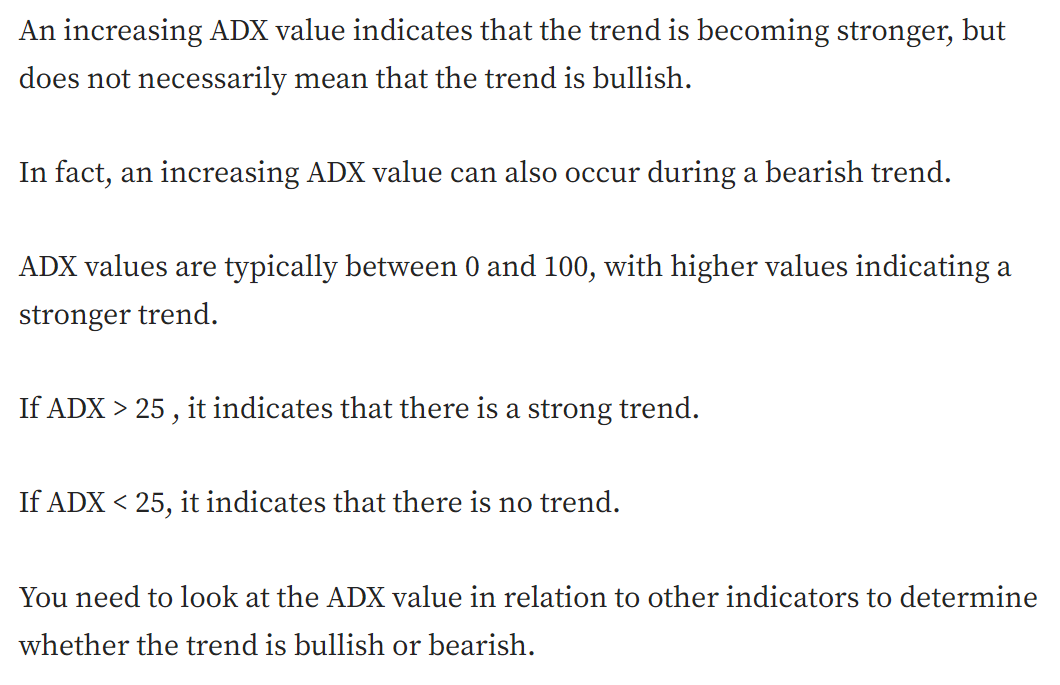

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,
Date,,,,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN,NaN,NaN,NaN
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN,NaN,NaN,NaN
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN,NaN,NaN,NaN
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000,0.680818,68.506640,32.089939
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571,0.686169,66.971051,32.278253


<Axes: xlabel='Date'>

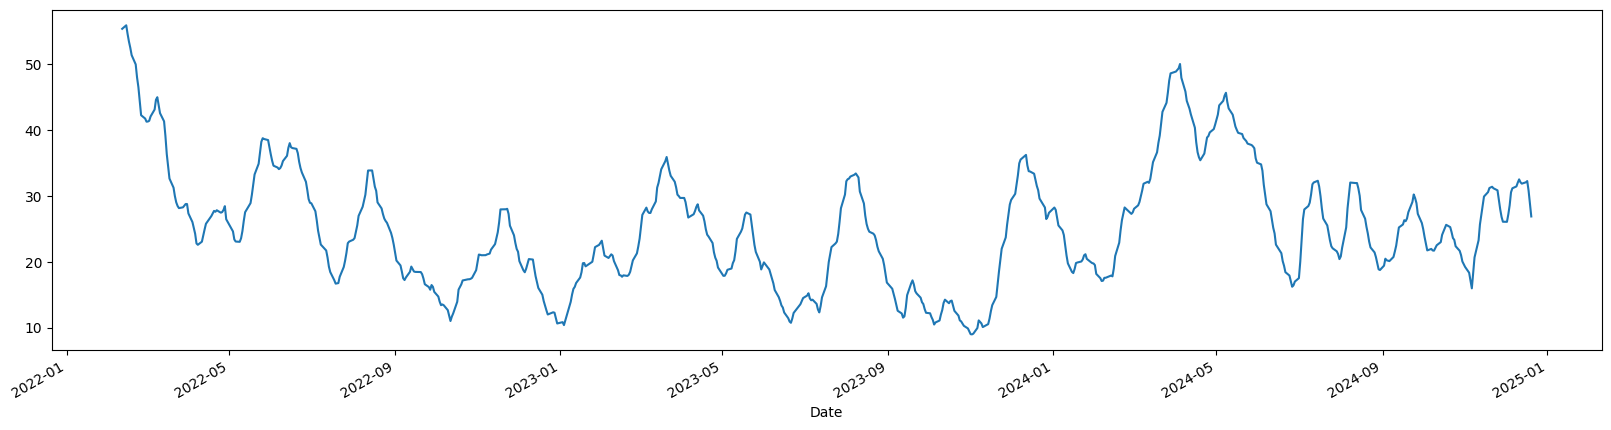

In [ ]:
data['ADX'] = ta.ADX(data['High'].values.squeeze(),
                     data['Low'].values.squeeze(),
                     data['Open'].values.squeeze(),
                     timeperiod=14)
display(data)

data['ADX'].plot(figsize=(20,5))



---



##Target, y: Returns for Tomorrow & Signal

###1) Returns 4 Tmrw

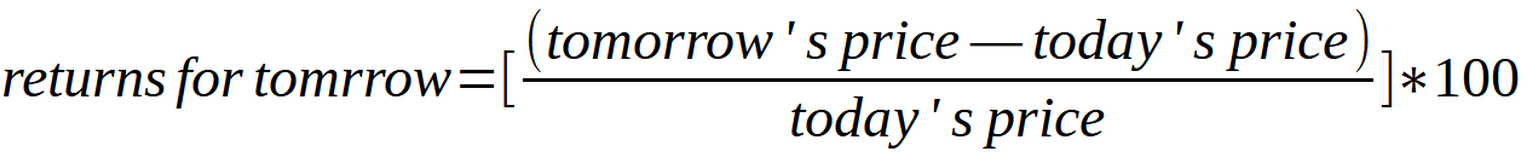

- "if you buy TODAY, this will be your returns for TOMORROW"
- we use the 'Returns 4 Tomorrow' to determine whether is GOOD or NO GOOD.
- If the Returns is positive, its GOOD.
- If the Returns is Negative, its BAD.
- in other words, we are going to use the Returns as a labelled indicator to train the model (to predict whether to buy or not).


Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,Returns_4_Tmrw
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,,
Date,,,,,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN,NaN,NaN,NaN,0.028057
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN,NaN,NaN,NaN,-0.013942
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN,NaN,NaN,NaN,0.017449
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN,NaN,NaN,NaN,0.016263
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN,NaN,NaN,NaN,0.020367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000,0.680818,68.506640,32.089939,-0.002257
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571,0.686169,66.971051,32.278253,-0.019000


<Axes: xlabel='Date'>

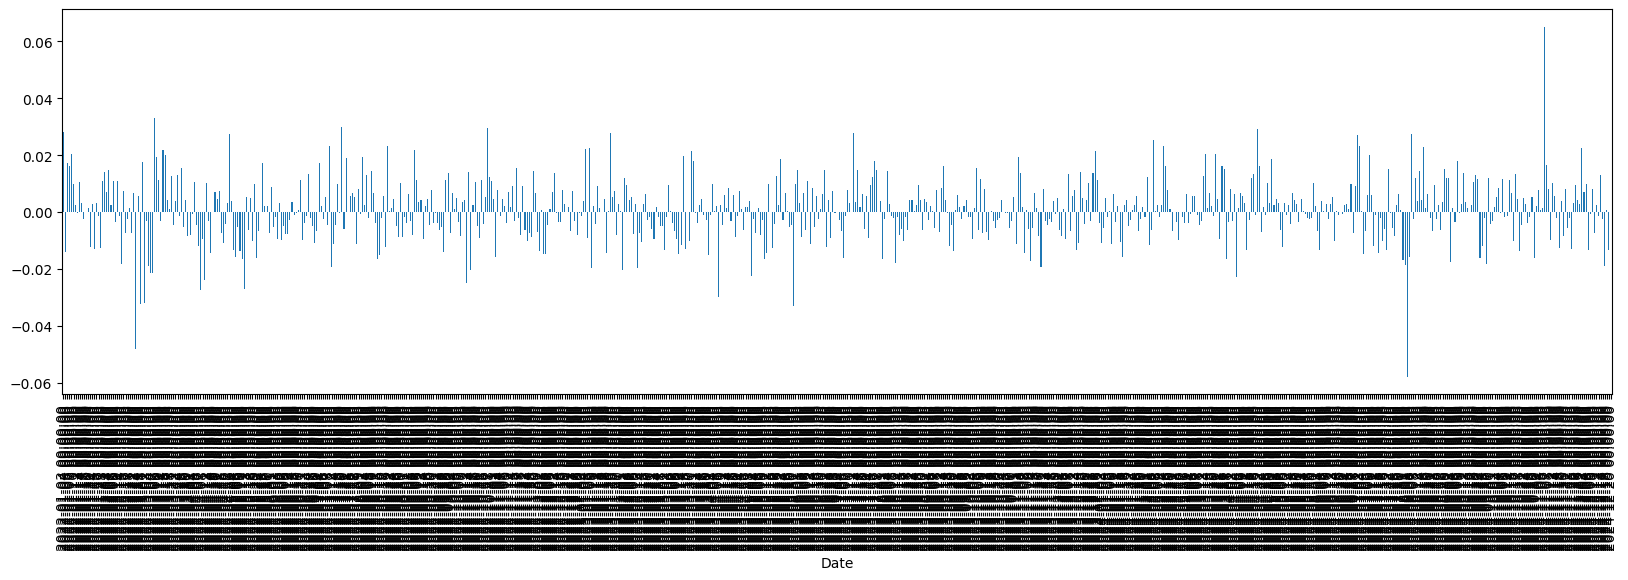

In [ ]:
# Define Target (y)
data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)
display(data)
#notice a new column 'Returns_4_Tmrw' has been created

data['Returns_4_Tmrw'].plot(kind='bar', figsize=(20,5))



---



###2) Creating the Signal

##np.where()
- If data['Returns_4_Tmrw'] > 0, then Signal will turn 1, else 0.
- 1: Means GOOD = BUY.
- 0: Means BAD = Don't BUY.
- in other words, the Returns column is the "labelled data" used for training

In [ ]:
data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)
display(data)

#notice a new column 'signal' has been created
#1 means BUY for that day
#0 means DON'T BUY for that day

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,Returns_4_Tmrw,Actual_Signal
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,,,
Date,,,,,,,,,,,,,,
2022-01-03,25.504267,29.809090,29.845453,29.745455,29.818180,1771660,NaN,NaN,NaN,NaN,NaN,NaN,0.028057,1
2022-01-04,26.219852,30.645454,30.709089,30.009090,30.045454,5813720,0.028057,NaN,NaN,NaN,NaN,NaN,-0.013942,0
2022-01-05,25.854286,30.218182,30.772726,30.063637,30.727272,5120060,-0.013942,NaN,NaN,NaN,NaN,NaN,0.017449,1
2022-01-06,26.305408,30.745455,30.745455,29.963636,29.981817,5170110,0.017449,NaN,NaN,NaN,NaN,NaN,0.016263,1
2022-01-07,26.733204,31.245455,31.245455,30.945454,31.045454,5531460,0.016263,NaN,NaN,NaN,NaN,NaN,0.020367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-16,44.310001,44.310001,44.330002,43.740002,43.740002,4691800,0.013032,0.873281,43.395000,0.680818,68.506640,32.089939,-0.002257,0
2024-12-17,44.209999,44.209999,44.299999,44.139999,44.209999,4413300,-0.002257,0.890969,43.563571,0.686169,66.971051,32.278253,-0.019000,0




---



#Step 4: Train Test Split

##4a) Display y and X

In [7]:
y, X = get_target_features(data)

In [8]:
y.head()

,Actual_Signal
Date,
2022-02-11,0
2022-02-14,0
2022-02-15,1
2022-02-16,0
2022-02-17,0


In [9]:
X.head()

Price,VOLATILITY,CORR,RSI,ADX
Ticker,,,,
Date,,,,
2022-02-11,0.980411,0.678399,78.073241,55.404622
2022-02-14,0.893955,0.803477,77.138863,55.937452
2022-02-15,1.059924,0.797975,65.778789,54.618301
2022-02-16,0.979498,0.737916,67.834537,53.467138
2022-02-17,1.019413,0.641699,63.712751,52.524661


##4b) Split 80% for Training and 20% for Testing

In [10]:
split = int(0.8*len(X))
#80% of the total number of rows

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
#X[:split] means from row 0 to row number 'split'
#X[split:] means from row 'split' until the last row



---



#Step 5: Use StandardScaler() to Scale the X

##5a) Import the StandardScaler()

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##5b) Scale X_train and X_test

In [12]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**sc.fit_transform(X_train): **
- The scaling parameters are learned from the training data and are stored in the scaler object.

**sc.transform(X_test): **
- This method transforms the test data using the scaling parameters that were learned from the training data.
- The test data is not scaled again, because this would introduce noise into the data.

**In general, **
- Use **sc.fit_transform(X_train)** on the training data and then use **sc.transform(X_test)** on the test data.

- This will ensure that the training and test data are scaled in the same way and that the model makes accurate predictions on the test data.



---



#Step 6: Import Logistic Regression Model and Start Training

##6a) Importing and Training

In [13]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

##6b) Predicting y_pred

In [14]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

##6c) Showing the Probabilities for 0 and 1

In [15]:
probability = model.predict_proba(X_test)
print(probability)

[[0.62438665 0.37561335]
 [0.64648422 0.35351578]
 [0.62532695 0.37467305]
 [0.62393816 0.37606184]
 [0.62098808 0.37901192]
 [0.5916595  0.4083405 ]
 [0.57831335 0.42168665]
 [0.5724955  0.4275045 ]
 [0.56766604 0.43233396]
 [0.56613412 0.43386588]
 [0.56520269 0.43479731]
 [0.55822697 0.44177303]
 [0.55913534 0.44086466]
 [0.56113579 0.43886421]
 [0.56503289 0.43496711]
 [0.56746901 0.43253099]
 [0.58768377 0.41231623]
 [0.58204136 0.41795864]
 [0.57028344 0.42971656]
 [0.59597811 0.40402189]
 [0.57142438 0.42857562]
 [0.57352846 0.42647154]
 [0.56069392 0.43930608]
 [0.50790229 0.49209771]
 [0.48811091 0.51188909]
 [0.49286967 0.50713033]
 [0.4978734  0.5021266 ]
 [0.49640105 0.50359895]
 [0.49477184 0.50522816]
 [0.47699759 0.52300241]
 [0.48004076 0.51995924]
 [0.47282529 0.52717471]
 [0.47096369 0.52903631]
 [0.45913172 0.54086828]
 [0.45506982 0.54493018]
 [0.4453746  0.5546254 ]
 [0.43043567 0.56956433]
 [0.45787951 0.54212049]
 [0.46844431 0.53155569]
 [0.46868895 0.53131105]




---



#Step 7: Confusion Matrix and Accuracy Metric

In [16]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


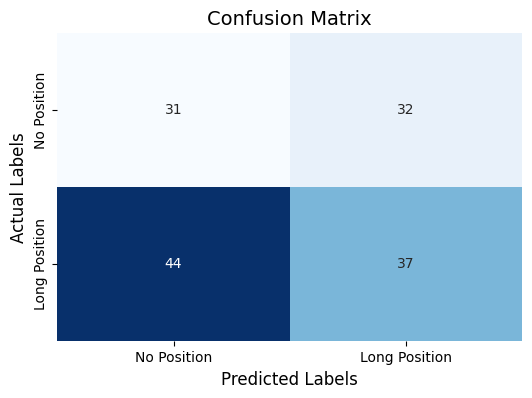




               precision    recall  f1-score   support

           0       0.41      0.49      0.45        63
           1       0.54      0.46      0.49        81

    accuracy                           0.47       144
   macro avg       0.47      0.47      0.47       144
weighted avg       0.48      0.47      0.47       144



In [17]:
get_metrics(y_test, y_pred)

In [ ]:
#if the Accuracy (placed below the f1-score) is low... try
#1) putting in more metrics like SMA and Corr
#2) shortening the time period of testing
#3) change the ML model?



---



#Step 8: Backtesting Our Model

##8a) Obtaining our Backtest Data

[*********************100%***********************]  1 of 1 completed


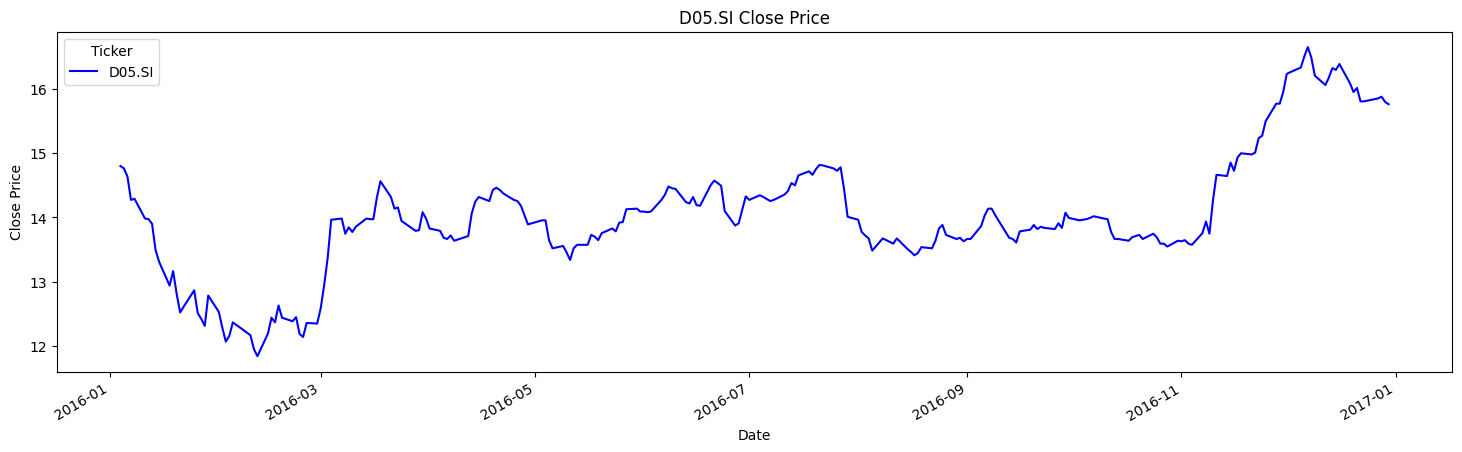

In [18]:
ticker = 'D05.SI'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
#df = pd.DataFrame(df['Close'])
#display(df)

#Plot---------------------------------------
df.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()

##8b) Creating Volatility + Correlation + RSI + ADX Columns as Features

In [19]:
#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'].squeeze(),14)
df['CORR'] = ta.CORREL(df['Close'].squeeze(), df['SMA'], 14)

#Create RSI------------------------------------------------------
df['RSI'] = ta.RSI(df['Close'].values.squeeze(), timeperiod=14)

#Create ADX------------------------------------------------------
df['ADX'] = ta.ADX(df['High'].values.squeeze(),
                   df['Low'].values.squeeze(),
                   df['Open'].values.squeeze(), timeperiod=14)

df = df.dropna()

display(df)

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,
Date,,,,,,,,,,,,
2016-02-12,7.881816,11.836363,11.945454,11.827272,11.863636,10606530,-0.009132,1.908630,12.344805,0.805924,25.203163,54.944768
2016-02-15,8.117910,12.190909,12.254545,11.918181,11.945454,13536600,0.029954,2.097070,12.314935,0.799982,33.922585,53.226452
2016-02-16,8.281356,12.436363,12.609090,12.109090,12.181818,13861650,0.020134,2.096633,12.284415,0.604675,39.206356,50.463219
2016-02-17,8.232926,12.363636,12.590909,12.300000,12.545454,7231415,-0.005848,1.971206,12.274026,0.502829,38.230879,47.897361
2016-02-18,8.408482,12.627272,12.709090,12.527272,12.581818,8166290,0.021323,2.044197,12.288961,0.332806,43.699348,45.137950
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,10.955626,15.809090,15.890909,15.672727,15.672727,2773430,0.000000,1.017874,16.200649,-0.692272,51.593561,32.532210
2016-12-27,10.987123,15.854545,15.854545,15.727272,15.781818,2037640,0.002875,0.962303,16.153896,-0.629115,52.838242,30.489468


##8c) Scale and Predict

In [20]:
df_scaled = sc.transform(df[['VOLATILITY','CORR', 'RSI', 'ADX']])

In [21]:
#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

display(df)

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,predicted_signal_4_tmrw
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,,
Date,,,,,,,,,,,,,
2016-02-12,7.881816,11.836363,11.945454,11.827272,11.863636,10606530,-0.009132,1.908630,12.344805,0.805924,25.203163,54.944768,1
2016-02-15,8.117910,12.190909,12.254545,11.918181,11.945454,13536600,0.029954,2.097070,12.314935,0.799982,33.922585,53.226452,1
2016-02-16,8.281356,12.436363,12.609090,12.109090,12.181818,13861650,0.020134,2.096633,12.284415,0.604675,39.206356,50.463219,1
2016-02-17,8.232926,12.363636,12.590909,12.300000,12.545454,7231415,-0.005848,1.971206,12.274026,0.502829,38.230879,47.897361,1
2016-02-18,8.408482,12.627272,12.709090,12.527272,12.581818,8166290,0.021323,2.044197,12.288961,0.332806,43.699348,45.137950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,10.955626,15.809090,15.890909,15.672727,15.672727,2773430,0.000000,1.017874,16.200649,-0.692272,51.593561,32.532210,1
2016-12-27,10.987123,15.854545,15.854545,15.727272,15.781818,2037640,0.002875,0.962303,16.153896,-0.629115,52.838242,30.489468,1


#8d) Create the Buying Strategy

- if we predict a 0 for that day, we don't buy
- if we predict a 1 for that day, we buy and we expect a Returns of

In [22]:
# Calculate the strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

display(df)

Price,Adj Close,Close,High,Low,Open,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,predicted_signal_4_tmrw,strategy_returns
Ticker,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,D05.SI,,,,,,,,
Date,,,,,,,,,,,,,,
2016-02-15,8.117910,12.190909,12.254545,11.918181,11.945454,13536600,0.029954,2.097070,12.314935,0.799982,33.922585,53.226452,1,0.029954
2016-02-16,8.281356,12.436363,12.609090,12.109090,12.181818,13861650,0.020134,2.096633,12.284415,0.604675,39.206356,50.463219,1,0.020134
2016-02-17,8.232926,12.363636,12.590909,12.300000,12.545454,7231415,-0.005848,1.971206,12.274026,0.502829,38.230879,47.897361,1,-0.005848
2016-02-18,8.408482,12.627272,12.709090,12.527272,12.581818,8166290,0.021323,2.044197,12.288961,0.332806,43.699348,45.137950,1,0.021323
2016-02-19,8.281356,12.436363,12.572727,12.363636,12.545454,6690970,-0.015119,2.075212,12.298052,0.327019,40.877192,42.992146,1,-0.015119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,10.955626,15.809090,15.890909,15.672727,15.672727,2773430,0.000000,1.017874,16.200649,-0.692272,51.593561,32.532210,1,0.000000
2016-12-27,10.987123,15.854545,15.854545,15.727272,15.781818,2037640,0.002875,0.962303,16.153896,-0.629115,52.838242,30.489468,1,0.002875




---



#Step 9: Using Pyfolio

Start date,2016-02-15
End date,2016-12-30
Total months,10
,Backtest
Annual return,37.3%
Cumulative returns,32.5%
Annual volatility,12.6%
Sharpe ratio,2.58
Calmar ratio,5.85
Stability,0.61
Max drawdown,-6.4%


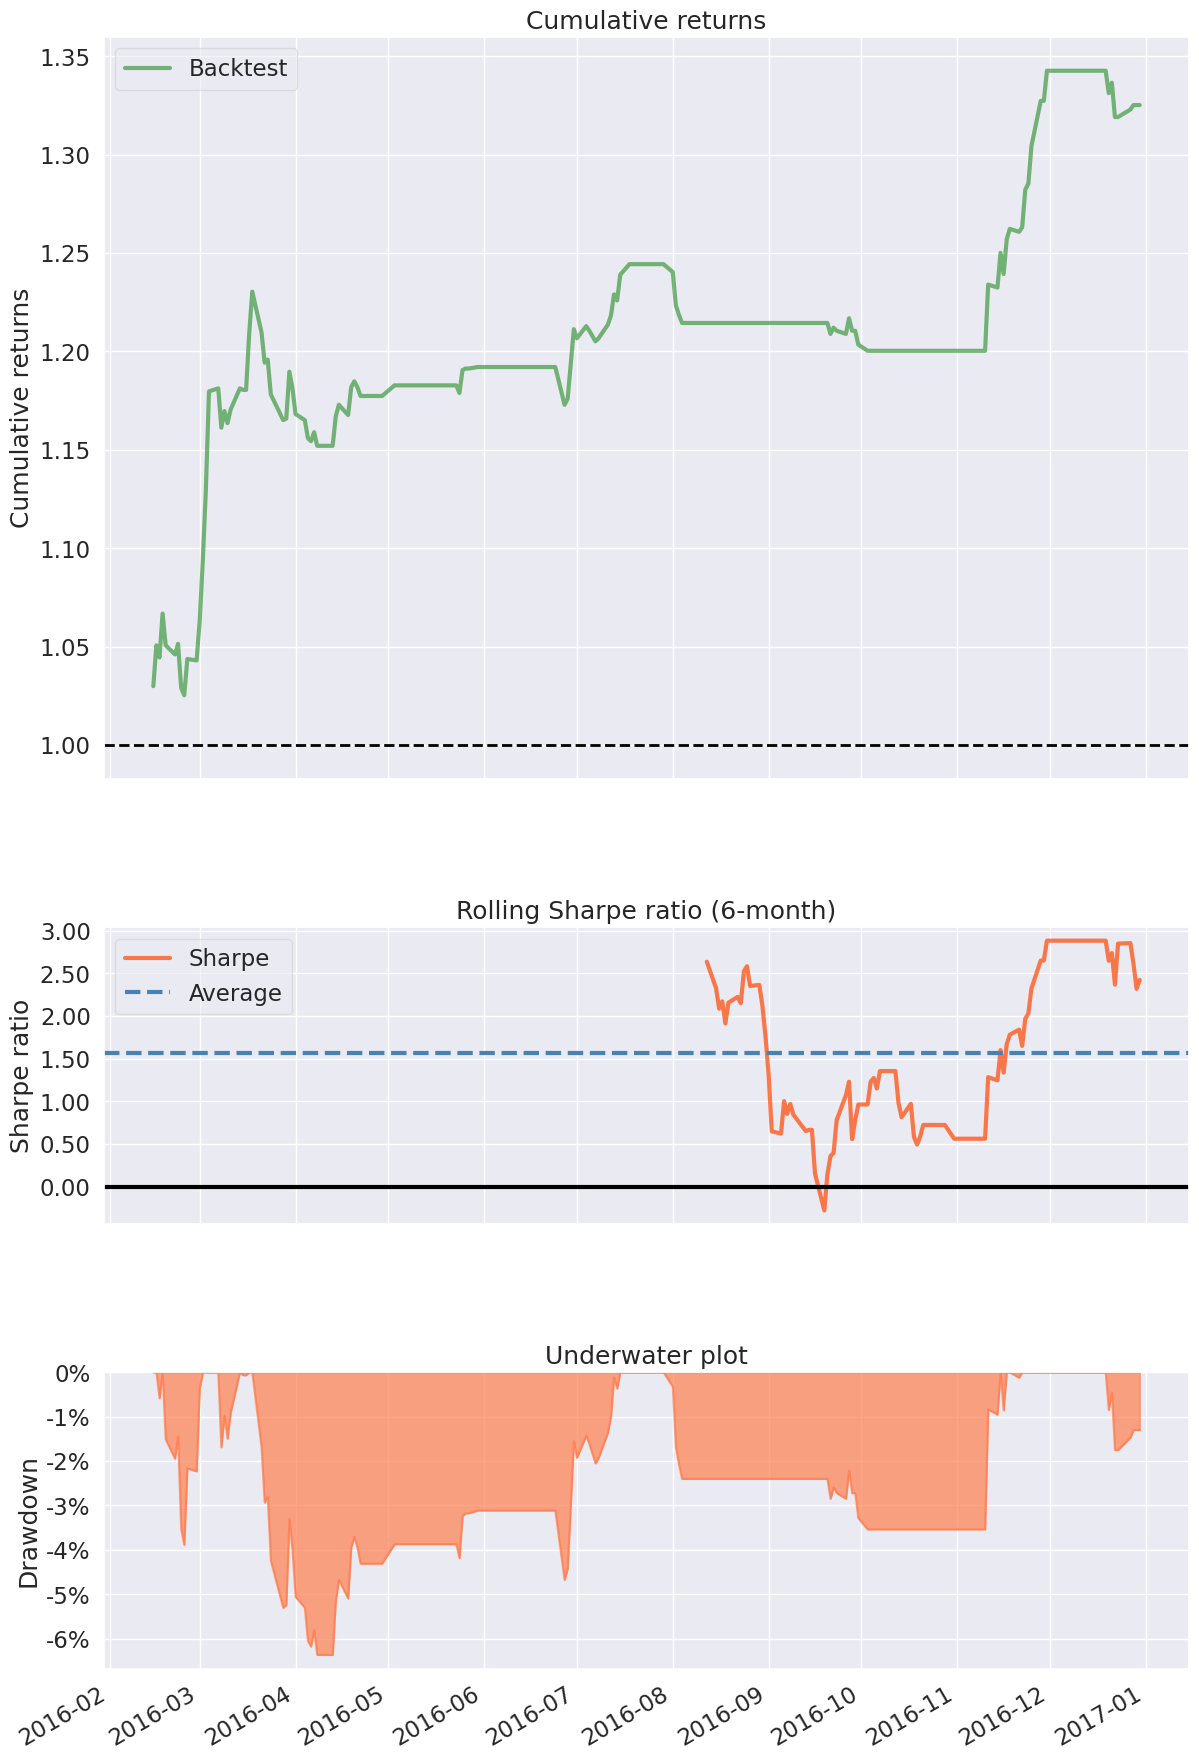

In [23]:
pf.create_simple_tear_sheet(df.strategy_returns)



---

#THE END



---

